Ok so this here sheet is going to be a testbed for the full image subtraction routine for SN photometry.

Note that following the original script from GROWTH 2020, this script will remove the processed directories when you run it, so careful!

Also note that we assume the images have WCS, but might need to be rotated.

The data directory should contain the sources images. The config directory needs some basic configuration files, which I should list at some point...(config.swarp and default.params and default.conv ) This original process gets around this by copying all the files iin at the very beginning. I'm doing it step-by-step, maybe dumb...

First import relevant packages:

In [1]:
import os  #Call commands from outside Python

# Running external programs
import subprocess
import shutil

from astropy.io import fits #FITS files handling

# Background subtraction
import photutils
#from photutils.detection import DAOStarFinder
from photutils.segmentation import detect_threshold, detect_sources
#from photutils import Background2D, MedianBackground # old version
from photutils.background import Background2D, MedianBackground 
from astropy.stats import sigma_clipped_stats, SigmaClip # statistics
from photutils.utils import circular_footprint



# For rotation
import astroalign as aa

# Plot
import matplotlib.pyplot as plt

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Set directory structure
cwd = os.getcwd()

print("You start from the directory:", cwd)

data_dir = os.path.join(cwd, 'data') # All the stacked files should be in here
proc_dir = os.path.join(cwd, 'processed') # all processes fits files.
out_dir = os.path.join(proc_dir, 'out') # output files are here
if os.path.isdir(proc_dir): # checks and removes if it exists. 
    shutil.rmtree(proc_dir)
os.mkdir(proc_dir)
config_dir = os.path.join(cwd, 'config') # various configuration files, should exist!
if os.path.exists(config_dir)==False:
    print("Error, config directory does not exist!")
    raise
    
for f in os.listdir(data_dir): # copy data into processed and change to it.
    shutil.copy2(os.path.join(data_dir, f), os.path.join(proc_dir, f))
os.chdir(proc_dir)
print("You are working in the image_subtraction/processed/ directory: ")
print("Full path:", proc_dir)

You start from the directory: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction
You are working in the image_subtraction/processed/ directory: 
Full path: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed


## Image Rotation

First we need to rotate the reference images to match the science images. This task will rotate all of the images to the first one, which is likely the first science image.

In [3]:
image_array=[]
for f in os.listdir(data_dir): # create list of raw images
    image_array.append(f)
    
image_array

['SUM_Aligned_20230308_B.fits',
 'SUM_Aligned_20230308_I.fits',
 'SUM_Aligned_20230309_B.fits',
 'SUM_Aligned_20230309_I.fits',
 'SUM_Aligned_20230310_B.fits',
 'SUM_Aligned_20230310_I.fits',
 'SUM_Aligned_20230311_B.fits',
 'SUM_Aligned_20230311_I.fits',
 'SUM_Aligned_20230312_B.fits',
 'SUM_Aligned_20230312_I.fits',
 'SUM_Aligned_20230313_B.fits',
 'SUM_Aligned_20230313_I.fits']

In [4]:
# create rotated directory
rot_dir = os.path.join(proc_dir, 'rotated')
if os.path.isdir(rot_dir): # checks and removes if it exists. 
    shutil.rmtree(rot_dir)
os.mkdir(rot_dir)

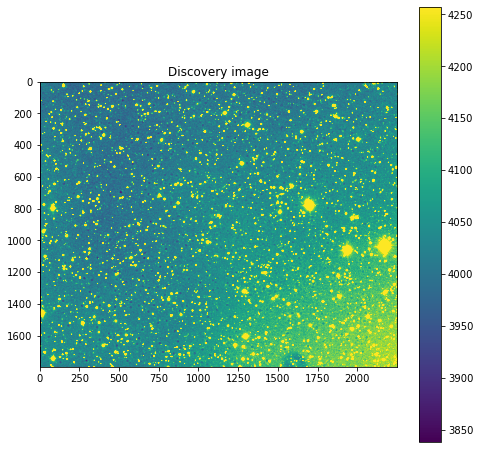

In [5]:
# Discovery image to rotate into
dis_image_name = os.path.join(data_dir, image_array[0])
dis_image = fits.open(dis_image_name)

#Plot that?
mean, median, std = sigma_clipped_stats(dis_image[0].data)
plt.figure(figsize=(8,8))

# Set the scale of the image based on its statistics
# p/m two sigma.
plt.imshow(dis_image[0].data, vmin=median-2*std, vmax=median+2*std)
plt.colorbar()
plt.title('Discovery image')
plt.show()

This line (needs to be done with all) are to deal with some kind of small/large emden order, see this: 

https://github.com/quatrope/astroalign/issues/70

In [6]:
dis_data = dis_image[0].data
dis = dis_data.byteswap().newbyteorder()

In [7]:
# loop through the other images
for i in range(len(image_array)-1):
    src_image_name = os.path.join(data_dir, image_array[i+1])
    src_image = fits.open(src_image_name)
    src_data = src_image[0].data
    src = src_data.byteswap().newbyteorder()
    #rotates src into dis
    img_aligned, footprint = aa.register(src, dis, detection_sigma=3.0) #detection criteria pretty random
    # create new file
    hdu = fits.PrimaryHDU(img_aligned)
    rot_name=image_array[i+1].split(".")[0]+"_Rotated.fits" # Do this in a smarter way later!
    hdu.writeto(rot_dir+"/"+rot_name, overwrite = True)

That should do it - maybe should check via AstroImagej, but worked in testing.

## Subtraction Routine

This part comes from the GROWTH 2020 school, with my own modifications and dealing with some recent changes to the code. We'll start with a dependency check:

(for now skipping all reference to ds9, since that doesn't actually seem that useful atm.)

In [8]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0

#dependencies = [('sextractor', 'sex'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
#dependencies = [('sextractor', 'source-extractor'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
dependencies = [('sextractor', 'source-extractor'), ('SWarp', 'swarp'), ('psfex', 'PSFEx')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.")   

sextractor is installed properly as source-extractor. OK
SWarp is installed properly as swarp. OK
psfex is installed properly as psfex. OK
3 out of 3 external dependencies installed properly.

You are ready to continue.


In [9]:
# move to rotated directory we created above
os.chdir(rot_dir)
print("Full path:", rot_dir)

Full path: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/rotated


## Align the images

Use the AstrOmatic Swarp package to align the images.  Swarp relies on the astrometric information of the image (in other words, on the sky coordinates), therefore both the science and reference images must be astrometrically calibrated (for example, using the AstrOmatic SCAMP package).  In this module we assume that the input images are already calibrated. (the images from iTelescope are already calibrated, for example)

We should be trying to pass the entire list to swarp at once, methinks.

In [10]:
#rot_image_array=[]
swarp_filelist_name=config_dir+"/"+'swarp_filelist.txt'
swarp_filelist = open(swarp_filelist_name, 'w')
for f in os.listdir(rot_dir): 
    #rot_image_array.append(f)
    print(f)
    swarp_filelist.write(str(f) + "\n")
swarp_filelist.close()

SUM_Aligned_20230308_I_Rotated.fits
SUM_Aligned_20230309_B_Rotated.fits
SUM_Aligned_20230309_I_Rotated.fits
SUM_Aligned_20230310_B_Rotated.fits
SUM_Aligned_20230310_I_Rotated.fits
SUM_Aligned_20230311_B_Rotated.fits
SUM_Aligned_20230311_I_Rotated.fits
SUM_Aligned_20230312_B_Rotated.fits
SUM_Aligned_20230312_I_Rotated.fits
SUM_Aligned_20230313_B_Rotated.fits
SUM_Aligned_20230313_I_Rotated.fits


Note in this next command the size of the box is basically dummy for right now. Should just be square at least...

In [11]:
# Swarp command
# had to change capitalization of SWarp!
try:
    #command = "swarp %s %s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (sci_image_name, ref_image_name, os.path.join(config_dir, 'config.swarp'))
    command = "swarp @%s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (swarp_filelist_name, os.path.join(config_dir, 'config.swarp'))
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SWarp with exit error %s'%err)

# Gotta fix the names of the aligned images
swarp_filelist = open(swarp_filelist_name, 'r')
align_image_array=[]
for line in swarp_filelist:
    #print(line)
    align_image_array.append(line.strip().replace(".fits", ".resamp.fits").replace('data','processed'))
#sci_image_aligned_name = sci_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
#ref_image_aligned_name = ref_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
swarp_filelist.close()

Executing command: swarp @/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/config/swarp_filelist.txt -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/config/config.swarp -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900


> 
----- SWarp 2.41.5 started on 2024-02-28 at 13:57:38 with 12 threads

> Examining input data ...
> Looking for SUM_Aligned_20230308_I_Rotated.fits ...
> Looking for SUM_Aligned_20230309_B_Rotated.fits ...
> Looking for SUM_Aligned_20230309_I_Rotated.fits ...
> Looking for SUM_Aligned_20230310_B_Rotated.fits ...
> Looking for SUM_Aligned_20230310_I_Rotated.fits ...
> Looking for SUM_Aligned_20230311_B_Rotated.fits ...
> Looking for SUM_Aligned_20230311_I_Rotated.fits ...
> Looking for SUM_Aligned_20230312_B_Rotated.fits ...
> Looking for SUM_Aligned_20230312_I_Rotated.fits ...
> Looking for SUM_Aligned_20230313_B_Rotated.fits ...
> Looking for SUM_Aligned_20230313_I_Rotated.fits ...
> Creating NEW output image ...
> Creating NEW weight-map ...
> 
------- Output File swarpout.fits:
    "no ident"  WEIGHTED  no ext. header  1800x900  32 bits (floats)
    Center: 1.12e+03,899   1.8e+03x900  Scale: 1x1 /pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X

> Loading input d

> Resampling SUM_Aligned_20230312_I_Rotated.fits ...
> Resampling line:      0 / 900    
> Resampling line:    333 / 900    
> Resampling line:    666 / 900    
> 
-------------- File SUM_Aligned_20230313_B_Rotated.fits:
    "no ident"  unweighted  no ext. header  2250x1800  32 bits (floats)
    Center: 1.12e+03,900   2.25e+03x1.8e+03  Scale: 1x1 /pixel
    Gain: 4 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X
> Setting up background maps ...
> Setting up background map at line:    512 / 1800   
> Setting up background map at line:   1024 / 1800   
> Setting up background map at line:   1536 / 1800   
> Filtering background map(s) ...
> Computing backgound d-map ...
> Computing backgound-noise d-map ...
    Background: 614.8325   RMS: 44.46974

> Reading SUM_Aligned_20230313_B_Rotated.fits
> Resampling SUM_Aligned_20230313_B_Rotated.fits ...
> Resampling line:      0 / 900    
> Resampling line:    333 / 900    
> Resampling line:    666 / 900    
> 
-------------- File SUM_Aligned_

Success!


> Resampling line:    666 / 900    
> Closing files ...
> 
> All done (in 1.1 s)


In [12]:
align_image_array

['SUM_Aligned_20230308_I_Rotated.resamp.fits',
 'SUM_Aligned_20230309_B_Rotated.resamp.fits',
 'SUM_Aligned_20230309_I_Rotated.resamp.fits',
 'SUM_Aligned_20230310_B_Rotated.resamp.fits',
 'SUM_Aligned_20230310_I_Rotated.resamp.fits',
 'SUM_Aligned_20230311_B_Rotated.resamp.fits',
 'SUM_Aligned_20230311_I_Rotated.resamp.fits',
 'SUM_Aligned_20230312_B_Rotated.resamp.fits',
 'SUM_Aligned_20230312_I_Rotated.resamp.fits',
 'SUM_Aligned_20230313_B_Rotated.resamp.fits',
 'SUM_Aligned_20230313_I_Rotated.resamp.fits']

And AstroImageJ verifies this basically looks right - but notice again the cropping might not make that such sense.

# Background Subtraction
- Mask sources in images
- Use 3 sigma clipping to filter data and accurately measure the backgorund
- Then split image into 300x300 pixel boxes and apply 2x2 median filter

That was the original. We are going to (for the first image)

1) look at the scalar background
2) look at the 2D background with no mask
3) look at the 2D background a mask

And then assume (3) is best and go ahead with subtracting them all!

In [13]:
# Eventually do this for each image in the array.
image = fits.open(align_image_array[0])
hdr = image[0].header #save fits header

#estimate scalar background with sourcemask
sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
threshold = detect_threshold(image[0].data, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(image[0].data, threshold, npixels=10)
footprint = circular_footprint(radius=10) #watch this footprint value, should be inspected!
mask = segment_img.make_source_mask(footprint=footprint)
mean, median, std = sigma_clipped_stats(image[0].data, sigma=3.0, mask=mask)
print((mean, median, std))  

(2863.6348, 2861.8376, 71.359024)


Somehow we should evaluate that...

ok but I think for real we just SKIP those scalar, and go right for the 2D background estimator (50x50 box, 3x3 median filter):

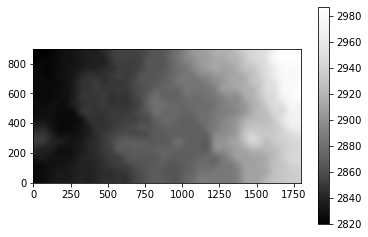

In [14]:
bkg_estimator = MedianBackground()
sigma_clip = SigmaClip(sigma=3.0)
bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar()

I suppose there is some effect of the background stars here - since we are not doing any masking. Let's try the same mask from above, and see if it gets any better?

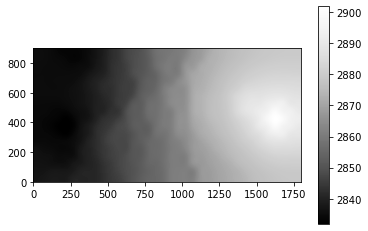

In [15]:
bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar()

yyyeaahh I guess that's better, the background should probably be NOT bumpy at all. So use this and background subtract everything.

(Background goes negative here, I had real problems in AIJ with that....)

In [16]:
# Do this for each image in the array.
bkg_subtract_array=[]
for i in range(len(align_image_array)):
    image = fits.open(align_image_array[i])
    hdr = image[0].header #save fits header
    # measure and subtract the background
    bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)
    bkg_subtract_name=align_image_array[i].replace(".resamp.fits", "_bkgsub.fits")
    bkg_subtract_array.append(bkg_subtract_name)
    image[0].data = image[0].data - bkg.background
    hdu_image_sub = fits.PrimaryHDU(image[0].data)
    hdu_image_sub.writeto(bkg_subtract_name,overwrite=True)

These images look right, but I did get an error that these images are now double precision, whereas AIJ expects single precision. Fine for now?


In [17]:
bkg_subtract_array

['SUM_Aligned_20230308_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230309_B_Rotated_bkgsub.fits',
 'SUM_Aligned_20230309_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230310_B_Rotated_bkgsub.fits',
 'SUM_Aligned_20230310_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230311_B_Rotated_bkgsub.fits',
 'SUM_Aligned_20230311_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230312_B_Rotated_bkgsub.fits',
 'SUM_Aligned_20230312_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230313_B_Rotated_bkgsub.fits',
 'SUM_Aligned_20230313_I_Rotated_bkgsub.fits']

## PSF matching

The atmosphere heavily affects the PSF of the images by determining the "seeing" conditions. The seeing for ground-based optical telescopes is usually measured as the FWHM of the imaging PSF.  Properties of the atmosphere can change very rapidly, so it is rare that science and reference images are characterized by the same seeing. Therefore their PSFs are usually different, which is a problem for image subtraction. 


### Generate the kernel for the convolution

The PSF of the science and reference images can be matched in several different ways.  Here we start by performing a first source extraction on both the science image.  We can use the catalogs of sources that we obtain for two main purposes: <br />
1. Measure the PSF of the science frame, using PSFex or photutils
2. Obtain instruments magnitudes that will be the basis for the zero-point calibration (see Photometry module).  


In [18]:
os.getcwd()

'/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/rotated'

In [19]:
cwd

'/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction'

In [20]:
os.path.exists('prepsfex.cat')

False

In [21]:
# use discovery image to extract sources.
# overwriting the catalog, but I guess that doesn't matter much.
# note that .sex file is the configuration for source-extractor.
rot_dir=os.path.join(proc_dir,'rotated')
dis_image_bkgsub_name = os.path.join(rot_dir, bkg_subtract_array[0])
source_extract_config_name=os.path.join(config_dir,"prepsfex.sex")
source_extract_cat_name=os.path.join(config_dir,"presfex.cat")
if os.path.exists(source_extract_cat_name): 
    os.remove(source_extract_cat_name)
    
# I think we need to be in the directory with the background files.
os.chdir(rot_dir)
#...and we need some configuration files in there as well.
copy_command='cp ' + os.path.join(config_dir,"default.conv") + " " + rot_dir
os.system(copy_command)
copy_command='cp ' + os.path.join(config_dir,"default.nnw") + " " + rot_dir
os.system(copy_command)

try:
    #command = "sextractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    #command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    command = "source-extractor %s -c %s -CATALOG_NAME %s -PARAMETERS_NAME %s -MAG_ZEROPOINT 25.0" % (dis_image_bkgsub_name, source_extract_config_name, source_extract_cat_name,os.path.join(config_dir,'default.param'))
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/rotated/SUM_Aligned_20230308_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/config/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/config/presfex.cat -PARAMETERS_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/config/default.param -MAG_ZEROPOINT 25.0

Success!


Now we use another software part of the AstrOmatic suite, PSFex, to measure the PSF of the science image(s). PSFex estimates the PSF based on the information present in the catalog generated with SExtractor.  Then, let's plot the PSF model obtained with PSFex

In [23]:
pwd

'/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/rotated'

In [24]:
# Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.
#if not os.path.isdir('out'): os.mkdir('out')

psfex_config_name=os.path.join(config_dir,"psfex_conf.psfex")
copy_command='cp ' + psfex_config_name + " " + rot_dir
os.system(copy_command)

try:
    #command = "psfex prepsfex.cat -c psfex_conf.psfex"
    command = "psfex %s -c %s" % (source_extract_cat_name,psfex_config_name)
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

psf_sci_image_name = os.path.join(out_dir,'proto_presfex.fits') # temporary name?
print(psf_sci_image_name)
psf_sci_image = fits.open(psf_sci_image_name)

plt.imshow(psf_sci_image[0].data[0], cmap='gray')

Executing command: psfex /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/config/presfex.cat -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/config/psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/out/proto_presfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



FileNotFoundError: [Errno 2] No such file or directory: '/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/out/proto_presfex.fits'